In [81]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
from interval_bounds import *
from data_generation import *
from ridge_poisoning import *
from sklearn import datasets
%load_ext autoreload
%autoreload 2

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn import tree

from sklearn import svm
from sklearn.metrics import hinge_loss

from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create dataset

In [101]:
n = 50 # number of data points
m = 5 # number of features
sigma = 0.1
lamb = 10
rho = 1
X, y, w = gen_synthetic_normal(n,m,sigma)
y = np.sign(y)

In [102]:
n_test = 50 # number of data points
X_test, y_test, w = gen_synthetic_normal(n_test,m,sigma)
y_test = np.sign(y_test)

In [103]:
U_upper, U_lower = find_interval_bounds_infty_uncertainty(X, rho)

In [104]:
l = lambda X,y: np.linalg.norm(X@np.linalg.pinv(X)@np.sign(y)-np.sign(y))**2

In [105]:
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of w: ", w.shape)

Shape of X:  (50, 5)
Shape of y:  (50, 1)
Shape of w:  (5, 1)


## Nominal Problem

In [106]:
loss, w_hat = solve_nominal(X,y,lamb=10)

In [107]:
print("Loss: ", loss)
print(l(X,y))

Loss:  21.297426769105417
14.319140568672964


## Robust Problem

In [108]:
loss, w_hat = solve_robust(X,y,rho=rho,lambda_=lamb)

In [109]:
print("Loss: ", loss)

Loss:  49.99999807078389


## Poisoned Problem

In [110]:
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of w: ", w.shape)

Shape of X:  (50, 5)
Shape of y:  (50, 1)
Shape of w:  (5, 1)


In [111]:
print((y.T@X).shape)
print((np.ones((m+1,m+1))[m:m+1,0:m]).shape)

(1, 5)
(1, 5)


In [123]:
def compare_plot(a,a_name,b,b_name,rhos):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('rho')
    ax1.set_ylabel(a_name, color=color)
    ax1.plot(rhos, a, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(b_name, color=color)  # we already handled the x-label with ax1
    ax2.plot(rhos, b, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Experiment 1

In [124]:
X_hats = []
losses = []
losses_svm = []
losses_log = []
losses_dt = []

losses_test = []
losses_svm_test = []
losses_log_test = []
losses_dt_test = []

dt_depth = []
dt_nodes = []

In [125]:
rhos = list(range(0,20,1))
for rho in rhos:
    print(rho)
    rho /= 10
    _, X_hat, _ = solve_poisoned_relaxed(X,y,lamb=lamb,rho=rho, mu=10)
    X_hats.append(X_hat)
    
    linearRegr = LinearRegression()
    linearRegr.fit(X_hat,y)
    losses.append(np.linalg.norm(X_hat@linearRegr.coef_.T - y,2))
    losses_test.append(np.linalg.norm(X_test@linearRegr.coef_.T - y_test,2))
    
    clf = svm.SVC(gamma="auto")
    clf.fit(X_hat, np.sign(y))
    y_pred = clf.predict(X_hat)
    losses_svm.append(hinge_loss(np.sign(y), y_pred))
    losses_svm_test.append(hinge_loss(np.sign(y_test), clf.predict(X_test)))
    
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_hat, np.sign(y))
    y_pred = logisticRegr.predict(X_hat)
    losses_log.append(log_loss(np.sign(y), y_pred))
    losses_log_test.append(log_loss(np.sign(y_test), logisticRegr.predict(X_test)))
    
#     clf = tree.DecisionTreeClassifier()
#     clf.fit(X_hat, np.sign(y))
#     dt_depth.append(clf.tree_.max_depth)
#     dt_nodes.append(clf.tree_.node_count)
#     y_pred = clf.predict(X_hat)
#     losses_dt.append(hinge_loss(np.sign(y), y_pred))
#     losses_dt_test.append(hinge_loss(np.sign(y_test), clf.predict(X_test)))


0


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


7


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


9


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


11


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


12


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


13


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


14


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


15


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


17


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


18


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


19


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


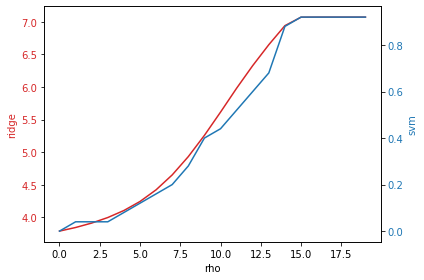

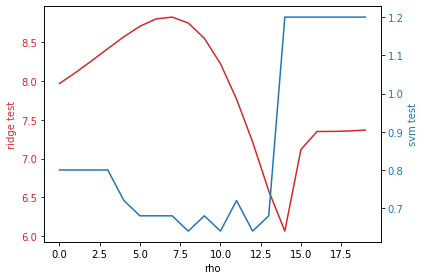

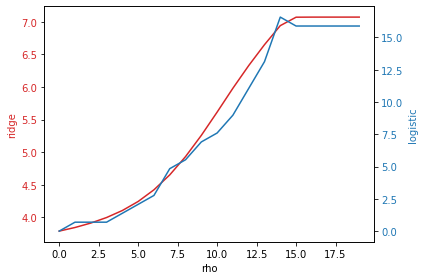

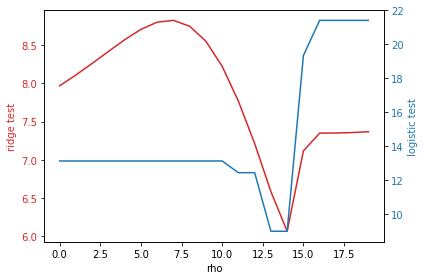

In [126]:
compare_plot(losses,"ridge",losses_svm,"svm",rhos)
compare_plot(losses_test,"ridge test",losses_svm_test,"svm test",rhos)
compare_plot(losses,"ridge",losses_log,"logistic",rhos)
compare_plot(losses_test,"ridge test",losses_log_test,"logistic test",rhos)
# compare_plot(losses,"ridge",losses_dt,"decision tree")
# compare_plot(losses_test,"ridge test",losses_dt_test,"decision tree test")

# plt.figure()
# plt.title("rho vs max depth")
# plt.plot(rhos,dt_depth)
# plt.figure()
# plt.title("rho vs number of nodes")
# plt.plot(rhos,dt_nodes)

## Experiment 2

In [127]:
X_hats = []
losses = []
losses_svm = []
losses_log = []
losses_dt = []

losses_test = []
losses_svm_test = []
losses_log_test = []
losses_dt_test = []

dt_depth = []
dt_nodes = []

In [128]:
rhos = list(range(0,20,2))
for rho in rhos:
    print(rho)
    rho /= 10
    _, X_hat, _ = solve_poisoned_relaxed(X,y,lamb=lamb,rho=rho, mu=10)
    X_hats.append(X_hat)
    
    linearRegr = LinearRegression()
    linearRegr.fit(X_hat,y)
    losses.append(accuracy_score(np.sign(X_hat@linearRegr.coef_.T),y))
    losses_test.append(accuracy_score(np.sign(X_test@linearRegr.coef_.T),y_test))
    
    clf = svm.SVC(gamma="auto")
    clf.fit(X_hat, np.sign(y))
    y_pred = clf.predict(X_hat)
    losses_svm.append(accuracy_score(np.sign(y), y_pred))
    losses_svm_test.append(accuracy_score(np.sign(y_test), clf.predict(X_test)))
    
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_hat, np.sign(y))
    y_pred = logisticRegr.predict(X_hat)
    losses_log.append(accuracy_score(np.sign(y), y_pred))
    losses_log_test.append(accuracy_score(np.sign(y_test), logisticRegr.predict(X_test)))
    
#     clf = tree.DecisionTreeClassifier()
#     clf.fit(X_hat, np.sign(y))
#     dt_depth.append(clf.tree_.max_depth)
#     dt_nodes.append(clf.tree_.node_count)
#     y_pred = clf.predict(X_hat)
#     losses_dt.append(hinge_loss(np.sign(y), y_pred))
#     losses_dt_test.append(hinge_loss(np.sign(y_test), clf.predict(X_test)))


0


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


12


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


14


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


18


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


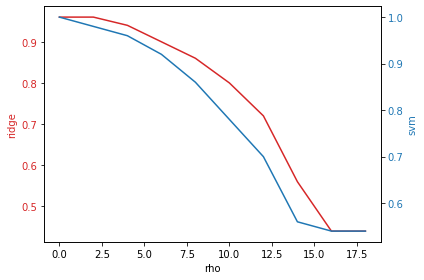

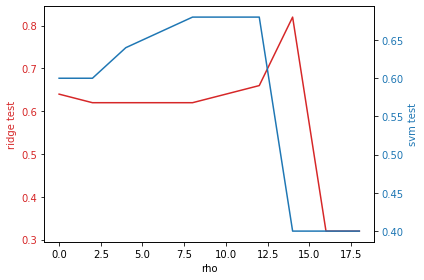

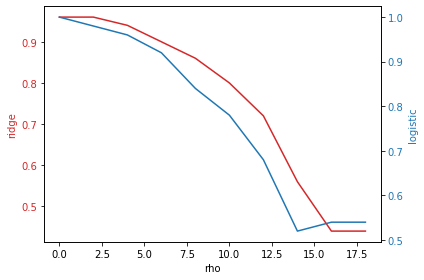

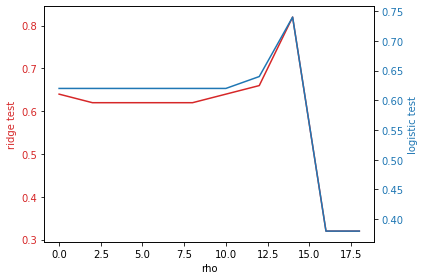

In [129]:
compare_plot(losses,"ridge",losses_svm,"svm",rhos)
compare_plot(losses_test,"ridge test",losses_svm_test,"svm test",rhos)
compare_plot(losses,"ridge",losses_log,"logistic",rhos)
compare_plot(losses_test,"ridge test",losses_log_test,"logistic test",rhos)
# compare_plot(losses,"ridge",losses_dt,"decision tree")
# compare_plot(losses_test,"ridge test",losses_dt_test,"decision tree test")

# plt.figure()
# plt.title("rho vs max depth")
# plt.plot(rhos,dt_depth)
# plt.figure()
# plt.title("rho vs number of nodes")
# plt.plot(rhos,dt_nodes)

## Experiment 3

In [133]:
X_hats = []
losses = []
losses_svm = []
losses_log = []
losses_dt = []

losses_test = []
losses_svm_test = []
losses_log_test = []
losses_dt_test = []

dt_depth = []
dt_nodes = []

In [134]:
rhos = list(range(0,40,2))
for rho in rhos:
    print(rho)
    rho /= 10
    _, X_hat, _ = solve_poisoned_relaxed(X,y,lamb=lamb,rho=rho, mu=10)
    X_hat, X_test = X_hat[:40], X_hat[40:]
    y_adv, y_test = y[:40], y[40:]
    X_hats.append(X_hat)
    losses.append(l(X_hat,y_adv))
    losses_test.append(l(X_test,y_test))
    
    clf = svm.SVC(gamma="auto")
    clf.fit(X_hat, np.sign(y_adv))
    y_pred = clf.predict(X_hat)
    losses_svm.append(hinge_loss(np.sign(y_adv), y_pred))
    losses_svm_test.append(hinge_loss(np.sign(y_test), clf.predict(X_test)))
    
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_hat, np.sign(y_adv))
    y_pred = logisticRegr.predict(X_hat)
    losses_log.append(log_loss(np.sign(y_adv), y_pred))
    losses_log_test.append(log_loss(np.sign(y_test), logisticRegr.predict(X_test)))
    
#     clf = tree.DecisionTreeClassifier()
#     clf.fit(X_hat, np.sign(y))
#     dt_depth.append(clf.tree_.max_depth)
#     dt_nodes.append(clf.tree_.node_count)
#     y_pred = clf.predict(X_hat)
#     losses_dt.append(hinge_loss(np.sign(y), y_pred))
#     losses_dt_test.append(hinge_loss(np.sign(y_test), clf.predict(X_test)))



0


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


12


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


14


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


18


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


20


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


22


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


24


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


26


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


28


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


30


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


32


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


36


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


38


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


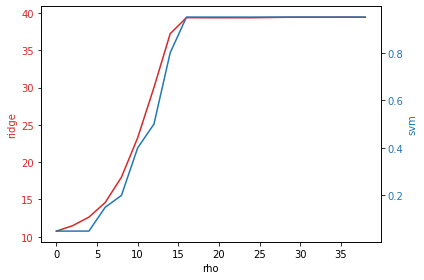

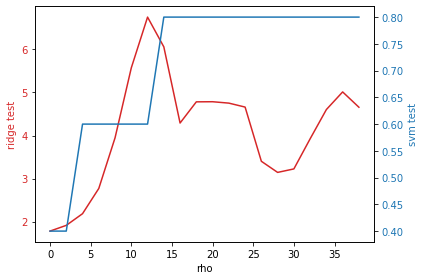

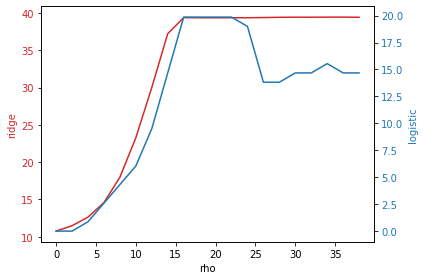

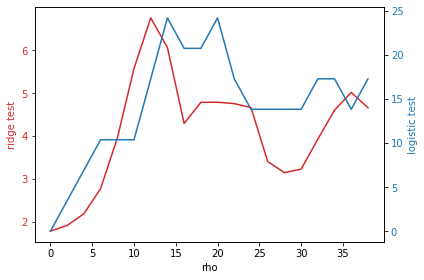

In [135]:
compare_plot(losses,"ridge",losses_svm,"svm",rhos)
compare_plot(losses_test,"ridge test",losses_svm_test,"svm test",rhos)
compare_plot(losses,"ridge",losses_log,"logistic",rhos)
compare_plot(losses_test,"ridge test",losses_log_test,"logistic test",rhos)

## Experiment 4

In [136]:
X_hats = []
losses = []
losses_svm = []
losses_log = []
losses_dt = []

losses_test = []
losses_svm_test = []
losses_log_test = []
losses_dt_test = []

dt_depth = []
dt_nodes = []

In [137]:
rhos = list(range(0,40,2))
for rho in rhos:
    print(rho)
    rho /= 10
    _, X_hat, _ = solve_poisoned_relaxed(X,y,lamb=lamb,rho=rho, mu=10)
    X_hat, X_test = X_hat[:40], X_hat[40:]
    y_adv, y_test = y[:40], y[40:]
    X_hats.append(X_hat)
    losses.append(accuracy_score(np.sign(X_hat@linearRegr.coef_.T),y_adv))
    losses_test.append(accuracy_score(np.sign(X_test@linearRegr.coef_.T),y_test))
    
    clf = svm.SVC(gamma="auto")
    clf.fit(X_hat, np.sign(y_adv))
    y_pred = clf.predict(X_hat)
    losses_svm.append(accuracy_score(np.sign(y_adv), y_pred))
    losses_svm_test.append(accuracy_score(np.sign(y_test), clf.predict(X_test)))
    
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_hat, np.sign(y_adv))
    y_pred = logisticRegr.predict(X_hat)
    losses_log.append(accuracy_score(np.sign(y_adv), y_pred))
    losses_log_test.append(accuracy_score(np.sign(y_test), logisticRegr.predict(X_test)))
    
#     clf = tree.DecisionTreeClassifier()
#     clf.fit(X_hat, np.sign(y))
#     dt_depth.append(clf.tree_.max_depth)
#     dt_nodes.append(clf.tree_.node_count)
#     y_pred = clf.predict(X_hat)
#     losses_dt.append(hinge_loss(np.sign(y), y_pred))
#     losses_dt_test.append(hinge_loss(np.sign(y_test), clf.predict(X_test)))



0


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


12


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


14


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


18


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


20


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


22


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


24


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


26


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


28


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


30


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


32


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


36


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


38


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


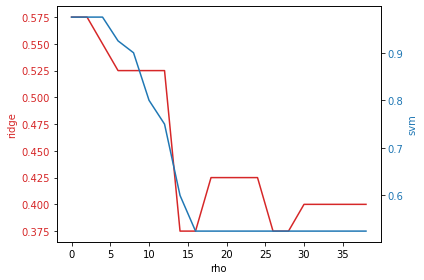

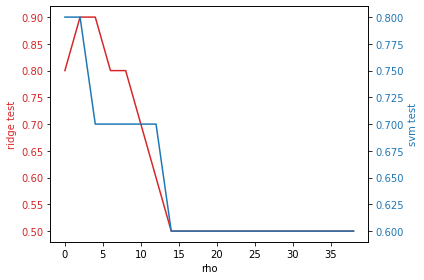

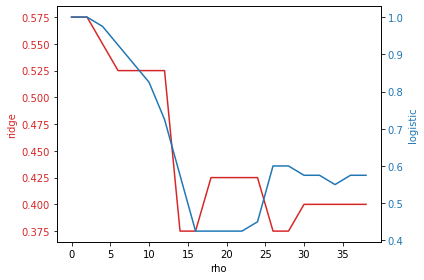

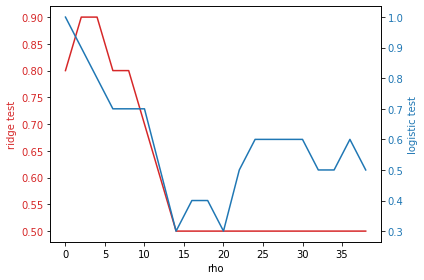

In [138]:
compare_plot(losses,"ridge",losses_svm,"svm",rhos)
compare_plot(losses_test,"ridge test",losses_svm_test,"svm test",rhos)
compare_plot(losses,"ridge",losses_log,"logistic",rhos)
compare_plot(losses_test,"ridge test",losses_log_test,"logistic test",rhos)

## SVM Experiment

In [36]:
from sklearn import svm
from sklearn.metrics import hinge_loss

In [37]:
for i in range(len(X_hats)):
    clf = svm.SVC()
    clf.fit(X_hats[i], np.sign(y))
    y_pred = clf.predict(X_hats[i])
    print(hinge_loss(np.sign(y), y_pred))

    clf = svm.SVC()
    clf.fit(X, np.sign(y))
    y_pred = clf.predict(X)
    print(hinge_loss(np.sign(y), y_pred))
    print()

0.0
0.0

0.1
0.0

0.6
0.0

0.6
0.0

0.6
0.0



/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/pyth

1814.672832323216


/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anandsranjan/opt/anaconda3/envs/ee227b_env/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
for X_hat in X_hats:
    plt.figure()
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    for i in range(X_hat.shape[0]):
        plt.scatter(X_hat[i],y[i])

In [ ]:
for X_hat in X_hats:
    print(np.linalg.norm(X_hat-X,2))